# Importando bibliotecas utilizadas

In [62]:
# Usado pra manipulação numérica
import numpy as np
from IPython.display import clear_output

# Usado pra manipulação de listas como dataframes
import pandas as pd

# Usado pra plot de gráficos
import matplotlib.pyplot as pl

# Usado pra integração numérica com o método runge-kutta de 4 ordem
from scipy.integrate import odeint

# Usado pra calculo dos minimos quadrados
from scipy.optimize import least_squares

# Usado pra achar número aleatório
import random

# Importação de dados utilizados

In [63]:
# Dados a partir de 2021 - com vacinados a serem usados no modelo
Dados = pd.read_csv('dados/Dados_novos_BAHIA.csv')

# Pegando coluna Vacinados do arquivo e preenchendo valores vazios com 0 usando o método fillna
vacinados_dados = Dados['Vacinados'].fillna(0)

# Dados a partir de 2020 - só com casos e mortes e a query limita os valores pra depois de 21/10/2020
mortes = pd.read_csv('dados/estado.csv').query("date >= '2021-01-01'").deaths.values

# Fazendo média móvel de vacinados

In [64]:
vacinados_dados_aux = np.copy(vacinados_dados)
for i in range(1,len(vacinados_dados_aux)):
    diff = vacinados_dados_aux[i] - vacinados_dados_aux[i-1]
    if diff < 0:
        vacinados_dados_aux[i-1] = vacinados_dados_aux[i]

novos_vacinados = np.diff(vacinados_dados_aux)
novos_vacinados = novos_vacinados.tolist()

# for i in range(72):
#     novos_vacinados.insert(0, 0)

# Importando PSI

In [65]:
Psi = pd.read_csv('dados/Psi.csv')
npd = len(Psi)

Nfo = 8
Psi = Psi.values
Psif = [[0]]*npd

for k in range(1, npd):
    if (k-Nfo) < 0 :
        Psif[k] = 1/k*sum(Psi[0:k])
    else:
        Psif[k] = 1/Nfo*sum(Psi[k-Nfo:k])

Psif.pop(0)

[0]

# Definindo o modelo

In [66]:
def SEIIHURD(y,t, args):
    k = 1/4
    gamma_a = 1/3.5
    gamma_s = 1/4
    gamma_h = 0.18
    gamma_u = 0.13342706158133355
    mi_u = 0.4
    qsi = 0.53
    h = 0.06
    h_v = 0
    mi_h = 0.15
    ome_h = 0.14
    ome_u = 0.29
    delta = 0.31
    p = 0.2
    
    # Utilizando betas e tempos do método dos minimos quadrados
    beta0, beta1, beta2, beta3, beta4, t1, t2, t3, t4 = args

    # Utilizando os betas em diferentes tempos
    if t<t1:
        beta=beta0    
    elif (t>=t1) and (t < t2):
        beta=beta1
    elif (t>=t2) and (t < t3):
        beta=beta2
    elif t>=t3 and (t < t4):
        beta=beta3
    elif t>=t4:
        beta=beta4
    
    beta_v = beta/2
    
    delta_av = 0.31
    delta_sv = 0.31
    phi_e = 0.8
    k_v=1/3
    p_v = 0.1
    gamma_av = 1/3.5
    gamma_sv = 1/4
    gamma_vu=0.26
    qsi_v = 0.99
    eps=0.7
    mi_vh=0.03
    mi_vu=0.25
    gamma_vh=0.08

    tau= 1/10000#novos_vacinados[int(t)]/14930634
         
    N=1#############
    #N=14930634#########
    psi= .5#Psif[int(t)]
    S=y[0]
    E=y[1]
    V=y[2]
    Sv=y[3]
    Ev=y[4]
    Ia=y[5]
    Is=y[6]
    Iav=y[7]
    Isv=y[8]
    H=y[9]
    Hv=y[10]
    U=y[11]
    Uv=y[12]
    R=y[13]
    Rv=y[14]
    D=y[15]
    Nw=y[16]
    NwV=y[17]

    dSdt = (-(1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - tau/N
    dEdt = ((1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - k*E
    dVdt = tau/N - phi_e*V - ((1-psi)*beta*V*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv))
    dSvdt =  phi_e*(1-eps)*V - ((1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) #- phi_e*eps*Sv
    dEvdt = ((1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)) - k_v*Ev
    dIadt = (1-p)*k*E - gamma_a*Ia
    dIsdt = p*k*E - gamma_s*Is
    dIavdt = (1-p_v)*k_v*Ev - gamma_av*Iav
    dIsvdt = p_v*k_v*Ev - gamma_sv*Isv   
    dHdt = h*qsi*gamma_s*Is + (1-mi_u+ome_u*mi_u)*gamma_u*U - gamma_h*H   
    dHvdt = h_v*qsi_v*gamma_sv*Isv + (1-mi_vu+ome_u*mi_vu)*gamma_vu*Uv - gamma_vh*Hv    
    dUdt = h*(1-qsi)*gamma_s*Is + ome_h*gamma_h*H - gamma_u*U
    dUvdt = h_v*(1-qsi_v)*gamma_sv*Isv + ome_h*gamma_vh*Hv - gamma_u*Uv
    dRdt = gamma_a*Ia + (1-h)*gamma_s*Is + (1-mi_h)*(1-ome_h)*gamma_h*H
    dRvdt = gamma_av*Iav + (1-h_v)*gamma_sv*Isv + (1-mi_vh)*(1-ome_h)*(gamma_vh*Hv) + phi_e*eps*V
    dDdt = (1-ome_h)*(mi_h*gamma_h*H +mi_vh*gamma_vh*Hv) + (1-ome_u)*(mi_u*gamma_u*U+mi_vu*gamma_vu*Uv)
    dNwdt = p*k*E + p_v*k_v*Ev
    dNwVdt = tau/N
        
    return [dSdt, dEdt, dVdt, dSvdt, dEvdt, dIadt, dIsdt, dIavdt, dIsvdt, dHdt, dHvdt, dUdt, dUvdt, dRdt, 
            dRvdt, dDdt, dNwdt, dNwVdt]

## Método dos mínimos quadrados aplicado ao SEIIHURD

In [67]:
def lq_SIR(pars, data, tempo, q0):
    mortos_dados = data
    
    beta0, beta1, beta2, beta3, beta4, tempo1, tempo2, tempo3, tempo4 = pars

    # Parametros usados
    parode = beta0, beta1, beta2, beta3, beta4, tempo1, tempo2, tempo3, tempo4

    # Integrar númericamente usando os parametros
    qs = odeint(SEIIHURD, q0, tempo, args=(parode,), mxstep=1000000)
    
    novos_mortos = np.diff(qs[:,-3])*14930634
    #define the standardized residuals
    errMortos = (novos_mortos - mortos_dados) / np.sqrt(novos_mortos+1)

    return np.r_[errMortos] 

## Definição de intervalos utilizados no fit

In [68]:
range_do_beta = [0, 5.]
primeiro_tempo = [0, 80]
segundo_tempo = [80, 120]
terceiro_tempo = [120, 250]
quarto_tempo = [250, 400]

intervalos = np.array([
    range_do_beta, 
    range_do_beta.copy(), 
    range_do_beta.copy(), 
    range_do_beta.copy(), 
    range_do_beta.copy(),
    primeiro_tempo,
    segundo_tempo, 
    terceiro_tempo, 
    quarto_tempo
])

# Método de busca do melhor fit

In [69]:
def Best_Fit(data, n_tries, tempo, q0):
    #NUMBER OF FITS
    #best error starts at inft 
    best_err = np.inf
    #aj the number of best fists 
    aj = 0

    for i in range(n_tries):
        clear_output(wait=True)

        #create a set of parameters in the interval
        par0 = np.random.rand(len(intervalos))
        par0 = intervalos[:,0] + par0 * (intervalos[:,1] - intervalos[:,0])
        #try to fit

        # try:
        print("estamos em", i)
        res = least_squares(
            lambda pars: lq_SIR(pars,data, tempo, q0), 
            par0, 
            bounds=(intervalos[:,0],\
                    intervalos[:,1]))
        ier = res.status
        #if converges
        if ier >= 1 and ier <= 4:
            if res.cost < best_err:
                #best_err = erro
                best_err = res.cost
                #best_pop = parametro
                best_pop = res.x
                #+1 best fit
                aj = aj +1
                print('achou',aj)
        # except:
        #     pass


    return best_pop

# Definindo valores iniciais

In [70]:
condicoes_iniciais = [
    0.8002151436282163 ,
    0.0023662791892471815,
    0,
    0,
    0,
    0.0015491725384642486,
    0.0004385474858925033,
    0,
    0,
    3.0058880370174367e-05,
    0.0,
    2.5542546092586197e-05,
    0.0,
    0.15650499264821266,
    0,
    9159/14930634,
    0.03581418879497971,
    0
]

# Chamando Melhor Fit

In [71]:
# Número total estimado de habitantes da bahia 
N = 14930634

numero_de_tentativas = 5 #Quanto maior mais certeza do resultado. Colocar em 100 para roda com mais certeza (Ou até maiws se for necessário)
tempo=np.arange(len(mortes))

best_pop=Best_Fit(np.diff(mortes), numero_de_tentativas, tempo, condicoes_iniciais)

beta0, beta1, beta2, beta3, beta4, t1, t2, t3, t4 = best_pop

#parameters
parode = [beta0, beta1, beta2, beta3, beta4, t1, t2, t3, t4]

#calls integrator
resultados = odeint(SEIIHURD, condicoes_iniciais, tempo, args=(parode,), mxstep=1000000)
resultados = resultados*N

# Salvando resultados: 
data_frame = pd.DataFrame(parode)
data_frame.to_csv('resultados/best_pop.csv')

estamos em 4


# Plotando curva fitada

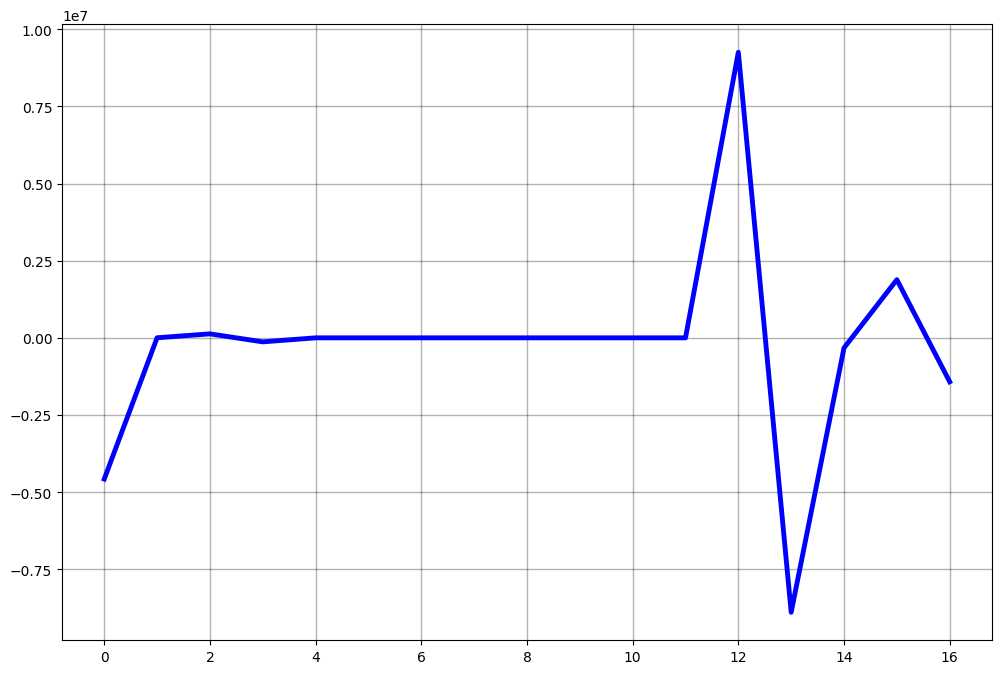

In [72]:
resultado_mortos = resultados[-3]

fig, ax = pl.subplots(figsize=(12,8))
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)

ts0 = np.arange(len(np.diff(mortes)))
novos_mortos = np.diff(mortes)
novos_mortos_resultado = np.diff(resultado_mortos)

# ax.plot(novos_mortos,color='black',zorder=3,label='Reported data')
ax.plot(novos_mortos_resultado,color='blue', linewidth=3.5,label='Fitted function')

ax.autoscale()
pl.show()